<a href="https://colab.research.google.com/github/descandon88/tesis_maestria/blob/main/Ecuador_contrade_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
# Librerías para visualizacion
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import re
import networkx as nx
from itertools import count
from itertools import combinations
from itertools import product
import statsmodels.api as sm
import urllib.request, json
!pip3 install geopandas
import geopandas
# -- set scientific notation to display numbers fully rather than exponential
pd.set_option('display.float_format', '{:.2f}'.format)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' 
import seaborn as sns
sns.set_style('whitegrid') # grids en dark background

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth',300)
print('librerías cargadas')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
librerías cargadas


# Análisis de los datos contrade HS4 de Ecuador

En esta notebook, lo que se pretende es realizar un análisis exhaustivo de la base de exportaciones de productos que contiene Ecuador para el capítulo 1 de la tesis.

Se importa la base desde drive

In [100]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [169]:
## Se importa la base de exportaciones de productos drive
df_base = pd.read_csv("/content/drive/MyDrive/eci/base/df_updated.csv")
df_short_name = pd.read_csv("/content/drive/MyDrive/eci/base/df_tipo_pro.csv")

print('dataframes cargados')

dataframes cargados


In [170]:
df_base['product_code'] = df_base['product_code'].apply(lambda x: '{0:0>4}'.format(x))
# df['product_code']  = df['product_code'] .apply(np.int64)

df_base.sample(n=6)
df_base.info()

,year,country_code,country_name,product_code,product_name,export_value
2421984,1997,ATF,French Southern and Antarctic Lands,3601,Explosives; propellent powders,0
2466704,2019,MHL,Marshall Islands,3702,"Photographic film in rolls, sensitised, unexposed, of any material other than paper, paperboard or textiles; instant print film in rolls, sensitised, unexposed",0
6711342,2019,AFG,Afghanistan,8804,Parachutes (including dirigible) and rotochutes; parts thereof and accessories thereto,0
1046348,2011,MDA,Moldova,2103,"Sauces and preparations therefor; mixed condiments and mixed seasonings, mustard flour and meal and prepared mustard",44523
2061939,2019,PAK,Pakistan,2929,"Nitrogen-function compounds, n.e.s. in chapter 29",61690
4179339,1996,IDN,Indonesia,6206,"Blouses, shirts and shirt-blouses; women's or girls' (not knitted or crocheted)",189826224


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7373271 entries, 0 to 7373270
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   year          int64 
 1   country_code  object
 2   country_name  object
 3   product_code  object
 4   product_name  object
 5   export_value  int64 
dtypes: int64(2), object(4)
memory usage: 337.5+ MB


In [171]:
# df_test.sample(n=6)
# df_test['hs_product_code'] = df_test['hs_product_code'].apply(np.int64)
df_short_name.rename(columns={"hs_product_code": "product_code"}, inplace=True)
df_short_name.rename(columns={"hs_product_name_short_en": "product_short_name"}, inplace=True)


df_short_name.sample(n=25)

df_short_name.info()
df_short_name['product_id'].nunique()
df_short_name['product_code'].nunique()

# df_test[ (df_test['country_name']=='Ecuador')].sort_values(by=['year'],ascending=False)[['index','country_iso_code','tech','year']][0:30]


,product_id,product_code,product_short_name
613,1150,4203,Leather apparel
1937,5576,190300,Tapioca
4631,8270,721250,"Flat rolled iron/non-alloy steel, <600mm, plated/coated"
844,1381,6501,Hat forms
3749,7388,550110,Nylon filament tow
41,130,31,Fertilisers
5370,9009,844210,Photo-typesetting & composing machines
2988,6627,382390,"Chemical products, nes"
116,653,0104,Sheep
3150,6789,401091,"Rubber conveyor belts, <20cm"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6406 entries, 0 to 6405
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   product_id          6406 non-null   int64 
 1   product_code        6406 non-null   object
 2   product_short_name  6406 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.3+ KB


6406

6396

### Aplico un merge para agregar el nombre corto del producto al dataframe principal

In [172]:
df_base['product_code'].nunique()
    # df_all = pd.merge(df_all,data[[anio_col,pais_col,prod_col,prod_code,value_col]],how='left',on=[anio_col,pais_col,prod_col])

# df['product_code'].nunique()
# df = pd.merge(df_base, df_short_name[['product_code','short_name']],how='right', on=['product_code']).copy()
df = pd.merge(df_base, df_short_name[['product_code','product_short_name']],how='inner', on='product_code').copy()

df.head()

1242

,year,country_code,country_name,product_code,product_name,export_value,product_short_name
0,1995,ABW,Aruba,0101,"Horses, asses, mules and hinnies; live",18008,Horses
1,1996,ABW,Aruba,0101,"Horses, asses, mules and hinnies; live",0,Horses
2,1997,ABW,Aruba,0101,"Horses, asses, mules and hinnies; live",0,Horses
3,1998,ABW,Aruba,0101,"Horses, asses, mules and hinnies; live",0,Horses
4,1999,ABW,Aruba,0101,"Horses, asses, mules and hinnies; live",14473,Horses


In [135]:
df_prueba = df[(df['product_code']=='0306')].copy()
df_prueba.head()

,year,country_code,country_name,product_code,product_name,export_value
125202,1995,ABW,Aruba,0306,"Crustaceans, in shell or not, live, fresh, chilled, frozen, dried, salted or in brine; crustaceans, in shell, cooked by steaming or boiling in water, chilled or not, frozen, dried, salted or in brine",0
125203,1996,ABW,Aruba,0306,"Crustaceans, in shell or not, live, fresh, chilled, frozen, dried, salted or in brine; crustaceans, in shell, cooked by steaming or boiling in water, chilled or not, frozen, dried, salted or in brine",1408
125204,1997,ABW,Aruba,0306,"Crustaceans, in shell or not, live, fresh, chilled, frozen, dried, salted or in brine; crustaceans, in shell, cooked by steaming or boiling in water, chilled or not, frozen, dried, salted or in brine",6620
125205,1998,ABW,Aruba,0306,"Crustaceans, in shell or not, live, fresh, chilled, frozen, dried, salted or in brine; crustaceans, in shell, cooked by steaming or boiling in water, chilled or not, frozen, dried, salted or in brine",56542
125206,1999,ABW,Aruba,0306,"Crustaceans, in shell or not, live, fresh, chilled, frozen, dried, salted or in brine; crustaceans, in shell, cooked by steaming or boiling in water, chilled or not, frozen, dried, salted or in brine",242243


Finding specific countries / products based on partial string matching
If you’re interested in finding data on certain countries / products but not sure how exactly these are spelled in the data (or are spelled with / without e.g. capital letters)

In [173]:
STRING = 'Netherland'
df[df['country_name'].str.contains(STRING)][['country_name']].drop_duplicates()

STRING = 'wine'
df[df['product_name'].str.contains(STRING,flags=re.IGNORECASE, regex=True)][['product_name']].drop_duplicates()

,country_name
156,Netherlands Antilles
3711,Netherlands


,product_name
11924,Swine; live
47696,"Meat of swine; fresh, chilled or frozen"
65582,"Edible offal of bovine animals, swine, sheep, goats, horses, asses, mules or hinnies; fresh, chilled or frozen"
1084954,"Wine of fresh grapes, including fortified wines; grape must other than that of heading no. 2009"
1090916,"Vermouth and other wine of fresh grapes, flavoured with plants or aromatic substances"
1156498,Wine lees; argol
3855058,"Twine, cordage, ropes and cables, whether or not plaited or braided; whether or not impregnated, coated, covered or sheathed with rubber or plastics"
3861020,"Twine, cordage or rope; knotted netting, made up fishing nets and other made up nets, of textile materials"
3866982,"Articles of yarn, strip or the like of heading no. 5404 or 5405; twine, cordage, rope or cables n.e.s. or included"
4302208,"Rags; used or new, scrap twine, cordage, rope and cables and worn out articles of twine, cordage, rope or cables, of textile materials"


##¿Cómo fue la evolución de exportaciones de petróleo del Ecuador? 

Text(0.5, 1.0, 'Exportaciones de Crudo del Ecuador desde 2000 - 2019')

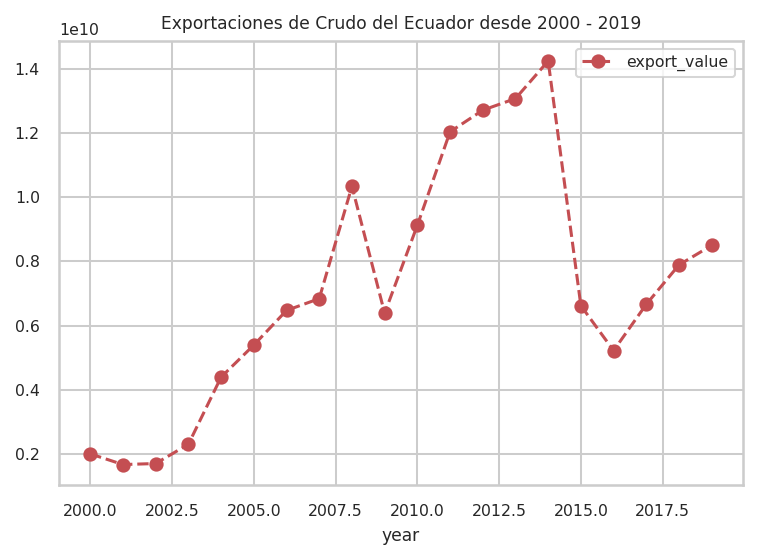

In [175]:
df_ec = df[ (df['country_code']=='ECU') & (df['year']<2020)& (df['year']>1999)].copy()

## 2709 refiere al código del producto de Petroleum oils and oils obtained from bituminous minerals; crude	
df_ec_2709 = df_ec[df_ec['product_code']=='2709']

df_ec_2709.plot(x='year', y='export_value', style="ro--")

plt.grid(True)
plt.title('Exportaciones de Crudo del Ecuador desde 2000 - 2019')
#showing the plot
plt.show()

<Figure size 576x360 with 0 Axes>

Text(0.0, 1.0, 'Figura 1: Exportaciones de Crudo/Petróleo del Ecuador desde 2000 - 2019')

Text(0.5, 0, 'Años')

Text(0, 0.5, 'USD 10 mil millones')

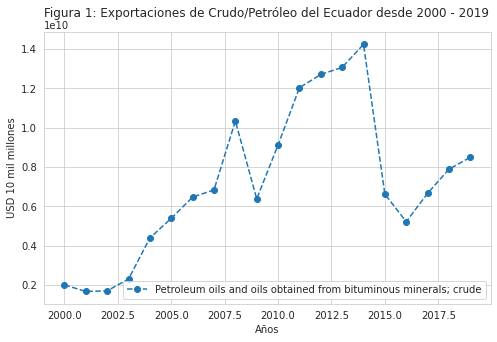

In [12]:
#df3 = df2[df2['product_name']=='Cars']

df1_ec = df_ec[df_ec['product_code']=='2709']
# df2_ec = df_ec[df_ec['product_code']=='803']
# df3_ec = df_ec[df_ec['product_code']=='603']
# df4_ec = df_ec[df_ec['product_code']=='306']
# df5_ec = df_ec[df_ec['product_code']=='1604']
# df6_ec = df_ec[df_ec['product_code']=='2710']


plt.figure(figsize=(8,5))

plt.plot("year", "export_value", marker='o', linestyle='dashed',data=df1_ec, label = "Petroleum oils, crude")
# plt.plot("year", "export_value", data=df2_ec, label = "Bananas, including plantains; fresh or dried")
# plt.plot("year", "export_value", data=df3_ec, label = "Flowers; cut flowers and flower buds of a kind suitable for bouquets or for ornamental purposes, fresh, dried, dyed, bleached, impregnated or otherwise prepared")
# plt.plot("year", "export_value", data=df4_ec, label = "Crustaceans, in shell or not, live, fresh, chilled, frozen, dried, salted or in brine; crustaceans, in shell, cooked by steaming or boiling in water, chilled or not, frozen, dried, salted or in brine")
# plt.plot("year", "export_value", data=df5_ec, label="Prepared or preserved fish; caviar and caviar substitutes prepared from fish eggs")
# plt.plot("year", "export_value", data=df6_ec, label="Petroleum oils, oils from bituminous minerals, not crude; preparations n.e.s. containing less than 70% petroleum oils, oils from bituminous minerals; these being the basic constituents of the preparations")

plt.title('Figura 1: Exportaciones de Crudo/Petróleo del Ecuador desde 2000 - 2019',
          fontsize=12,
    pad=15,
    loc="left")
plt.xlabel('Años')
plt.ylabel('USD 10 mil millones')

plt.legend()
plt.show()

Evolución de los 6 mayores productos de exportación en el 2019.

<Figure size 1470x1176 with 0 Axes>

Text(0.0, 1.0, 'Bananas y Mariscos han mantenido un crecimiento sostenido')

Text(0.126, 0.96, 'Figura 2: Evolución de los TOP 10 de mayor exportación en el 2019')

Text(0.5, 0, 'Años')

Text(0, 0.5, 'USD 10 mil millones')

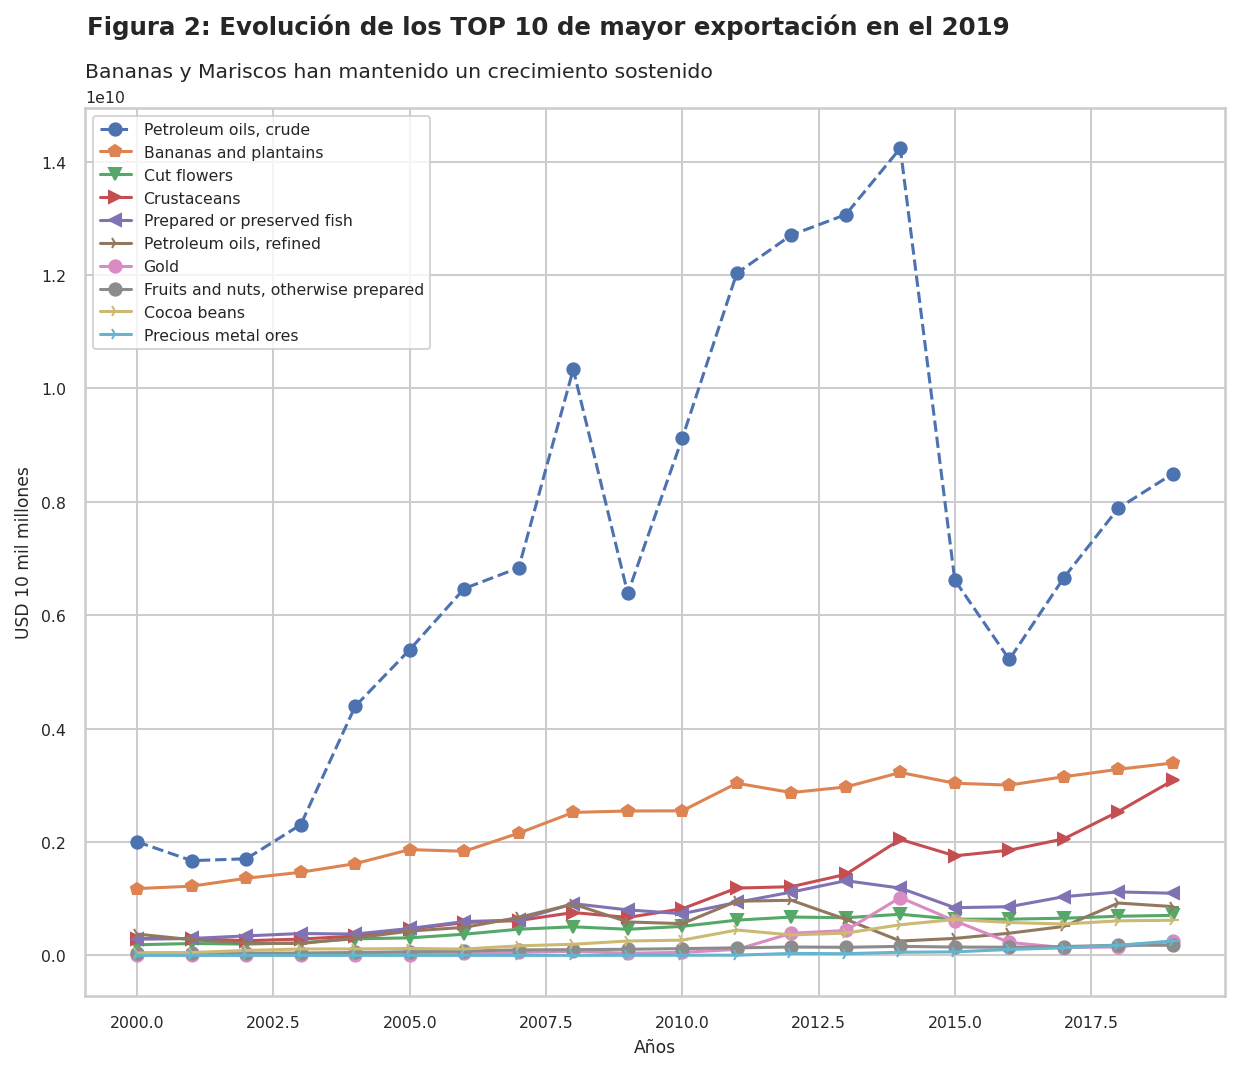

In [196]:

df1_ec = df_ec[df_ec['product_code']=='2709']
df2_ec = df_ec[df_ec['product_code']=='0803']
df3_ec = df_ec[df_ec['product_code']=='0603']
df4_ec = df_ec[df_ec['product_code']=='0306']
df5_ec = df_ec[df_ec['product_code']=='1604']
df6_ec = df_ec[df_ec['product_code']=='2710']
df7_ec = df_ec[df_ec['product_code']=='7108']
df8_ec = df_ec[df_ec['product_code']=='2008']
df9_ec = df_ec[df_ec['product_code']=='1801']
df10_ec = df_ec[df_ec['product_code']=='2616'] #Precious metal ores	




plt.figure(figsize=(10,8))

plt.plot("year", "export_value", marker='o', linestyle='dashed',data=df1_ec, label = "Petroleum oils, crude")
plt.plot("year", "export_value",marker='p', data=df2_ec, label = "Bananas and plantains")
plt.plot("year", "export_value",marker='v', data=df3_ec, label = "Cut flowers")
plt.plot("year", "export_value",marker='>', data=df4_ec, label = "Crustaceans")
plt.plot("year", "export_value",marker='<', data=df5_ec, label="Prepared or preserved fish")
plt.plot("year", "export_value",marker='4', data=df6_ec, label="Petroleum oils, refined")
plt.plot("year", "export_value", marker='o',data=df7_ec, label = "Gold")
plt.plot("year", "export_value", marker='o',data=df8_ec, label = "Fruits and nuts, otherwise prepared")
plt.plot("year", "export_value",marker='4', data=df9_ec, label="Cocoa beans") #1801
plt.plot("year", "export_value",marker='4', data=df10_ec, label="Precious metal ores") #1801


plt.title('Bananas y Mariscos han mantenido un crecimiento sostenido',  fontsize=10,
    pad=15,
    loc="left")
plt.suptitle(
    "Figura 2: Evolución de los TOP 10 de mayor exportación en el 2019",
    fontsize=12,
    fontweight="bold",
    x=0.126,
    y=0.96,
    ha="left",
)
plt.xlabel('Años')
plt.ylabel('USD 10 mil millones')

plt.legend()
plt.show()

##Evolución de los 6 productos No Petroleros (ni sus derivados) de mayor exportación en el 2019. 

<Figure size 1470x1176 with 0 Axes>

Text(0.0, 1.0, 'Oro mineral aparece como uno de los productos no tradicionales de exportación que emerge desde el 2011.')

Text(0.126, 0.96, 'Figura 3: Evolución de los 10 productos No Petroleros de mayor exportación en el 2019')

Text(0.5, 0, 'Años')

Text(0, 0.5, 'USD mil millones')

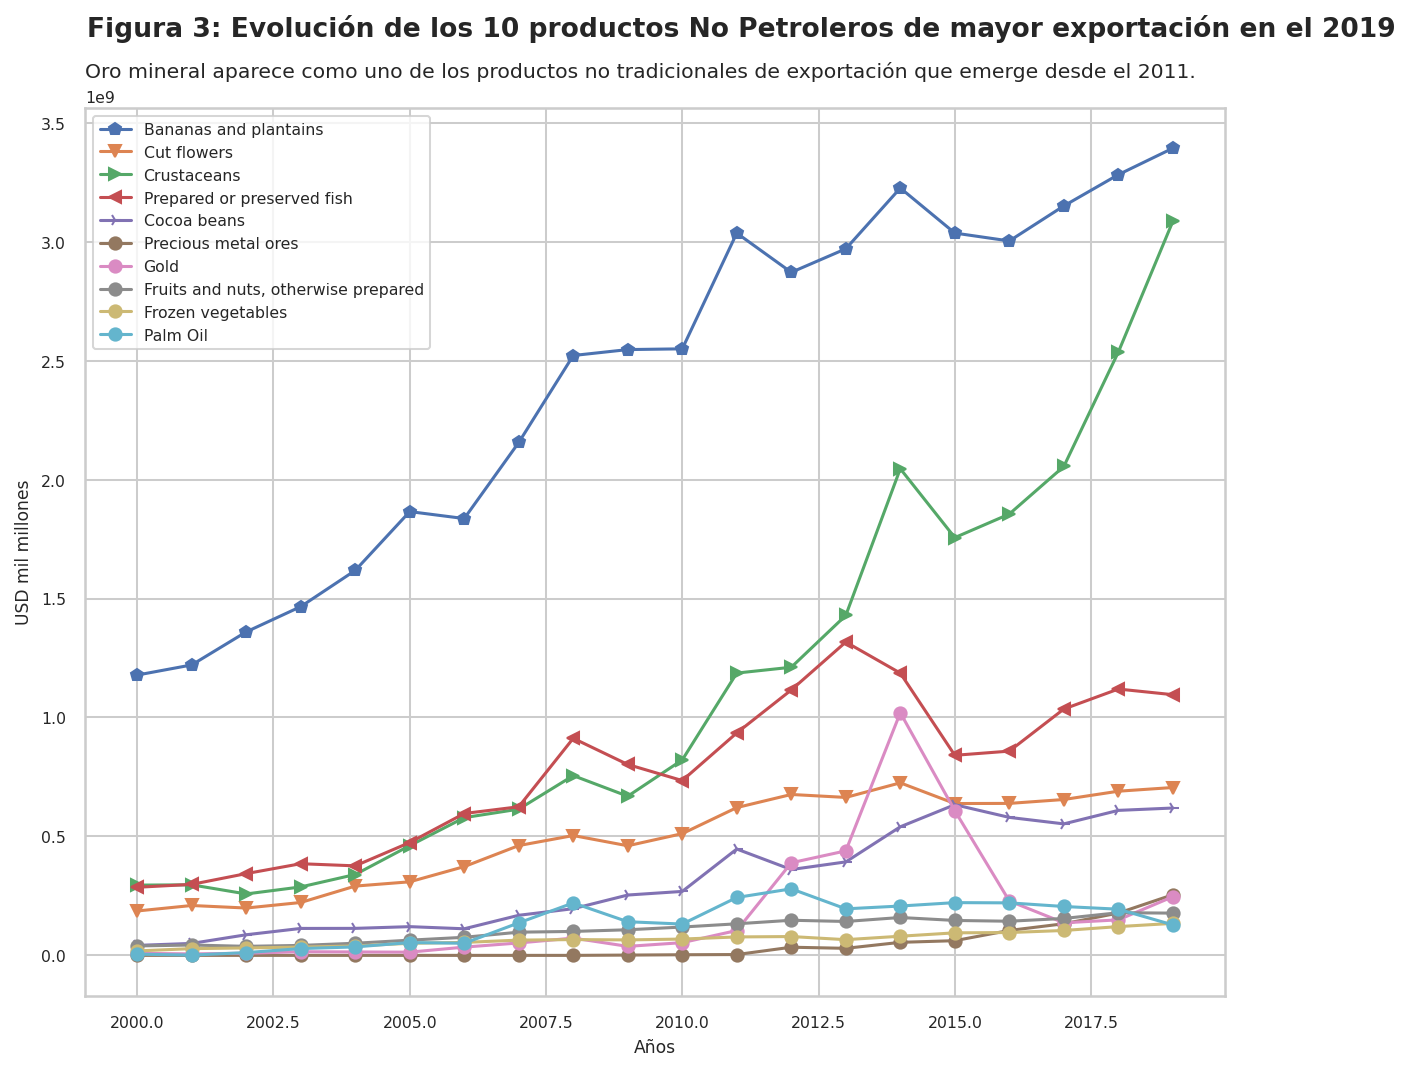

In [195]:

df1_ec = df_ec[df_ec['product_code']=='0803']
df2_ec = df_ec[df_ec['product_code']=='0603']
df3_ec = df_ec[df_ec['product_code']=='0306']
df4_ec = df_ec[df_ec['product_code']=='1604']
df5_ec = df_ec[df_ec['product_code']=='1801']
df6_ec = df_ec[df_ec['product_code']=='2616']
df7_ec = df_ec[df_ec['product_code']=='7108'] #Gold 2008
df8_ec = df_ec[df_ec['product_code']=='2008']
df9_ec = df_ec[df_ec['product_code']=='0710']#0710
df10_ec = df_ec[df_ec['product_code']=='1511']




plt.figure(figsize=(10,8))

plt.plot("year", "export_value",marker='p', data=df1_ec, label = "Bananas and plantains")
plt.plot("year", "export_value",marker='v', data=df2_ec, label = "Cut flowers")
plt.plot("year", "export_value",marker='>', data=df3_ec, label = "Crustaceans")
plt.plot("year", "export_value",marker='<', data=df4_ec, label="Prepared or preserved fish")
plt.plot("year", "export_value",marker='4', data=df5_ec, label="Cocoa beans")
plt.plot("year", "export_value", marker='o',data=df6_ec, label = "Precious metal ores")
plt.plot("year", "export_value", marker='o',data=df7_ec, label = "Gold")
plt.plot("year", "export_value", marker='o',data=df8_ec, label = "Fruits and nuts, otherwise prepared")
plt.plot("year", "export_value", marker='o',data=df9_ec, label = "Frozen vegetables")
plt.plot("year", "export_value", marker='o',data=df10_ec, label = "Palm Oil")



plt.title('Oro mineral aparece como uno de los productos no tradicionales de exportación que emerge desde el 2011.',  fontsize=10,
    pad=15,
    loc="left")
plt.suptitle(
    "Figura 3: Evolución de los 10 productos No Petroleros de mayor exportación en el 2019",
    fontsize=13,
    fontweight="bold",
    x=0.126,
    y=0.96,
    ha="left",
)
plt.xlabel('Años')
plt.ylabel('USD mil millones')

plt.grid(True)
plt.legend()
plt.show()

In [190]:

years=[2019]

df_ec_ex_2012 = df[(df['country_name']=='Ecuador')  & (df['year'].isin(years))].copy()
df_ec_ex_2016 = df[(df['country_name']=='Ecuador')  & (df['year'] == 2016) ].copy()

df_ec_ex_2012 = df_ec_ex_2012.groupby(['product_code','product_short_name','year'],as_index=False)['export_value'].sum()
df_ec_ex_2016 = df_ec_ex_2016.groupby(['product_code','product_name'],as_index=False)['export_value'].sum()


df_ec_ex_2012.sort_values(by=['export_value'],ascending=False,inplace=True)

df_ec_top10_2012 = df_ec_ex_2012.iloc[0:13, :].copy()
df_ec_top10_2012.sort_values(by=['export_value'],ascending=False,inplace=True)

df_ec_top10_2012.head(26)

,product_code,product_short_name,year,export_value
255,2709,"Petroleum oils, crude",2019,8495520256
62,0803,Bananas and plantains,2019,3392899328
21,0306,Crustaceans,2019,3085660672
144,1604,Prepared or preserved fish,2019,1095807616
256,2710,"Petroleum oils, refined",2019,860394496
44,0603,Cut flowers,2019,705645760
150,1801,Cocoa beans,2019,619411456
241,2616,Precious metal ores,2019,254867616
790,7108,Gold,2019,246594176
1217,9999,Commodities not specified according to kind,2019,244173872


In [17]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid', rc={'figure.dpi': 147},              
              font_scale=0.7)

fig, ax = plt.subplots(figsize=(9, 2))

top10 = df_ec_top10_2012['product_name'].value_counts().index[5:10]

ax.set_title('Exportaciones de Ecuador')

sns.barplot(x='product_name', y='export_value', data=df_ec_ex_2012, ax=ax, 
            order=top10, ci=None, 
            hue='year', hue_order=[2010, 2017])

ax.legend(bbox_to_anchor=(1, 1), title='year');

# ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

wrap_labels(ax, 10)
ax.figure



# Initialize a Figure and an Axes
# fig, ax = plt.subplots()

# Fig size
# fig.set_size_inches(9,9)

# Create horizontal bars
# ax.barh(y=df_ec_top10_2012.product_name, width=df_ec_top10_2012.export_value);
# plt.yticks(rotation='horizontal',wrap=True)
# plt.text(5, 10, t, fontsize=18, style='oblique', ha='center',
#          va='top', wrap=True)
# Add title
# ax.set_title('Exportaciones de Ecuador en 2012');

#Calculo de RCA

In [197]:
## Función para el cálculo de RCA

def calc_rca(data,pais_col,prod_col,prod2_col,anio_col,value_col,prod_code):
    """
      La función que calcula la RCA
    
    """
    print('Creando las combinaciones de país-producto-tiempo')
    df_all = pd.DataFrame(list(product(data[anio_col].unique(), data[pais_col].unique(),data[prod_col].unique())))
    df_all.columns=[anio_col,pais_col,prod_col]
    print('Se procede a fusionar los datos')
    df_all = pd.merge(df_all,data[[anio_col,pais_col,prod_col,prod2_col,prod_code,value_col]],how='left',on=[anio_col,pais_col,prod_col])
    df_all.loc[df_all[value_col].isnull(),value_col] = 0

    # En esta parte se calculan propiedades
    print('calculando')
    df_all['Xcpt'] = df_all[value_col]
    df_all['Xct'] = df_all.groupby([pais_col, anio_col])[value_col].transform(sum)
    df_all['Xpt'] = df_all.groupby([prod_col, anio_col])[value_col].transform(sum)
    df_all['Xt'] = df_all.groupby([anio_col])[value_col].transform('sum')

    df_all['RCAcpt'] = (df_all['Xcpt']/df_all['Xct'])/(df_all['Xpt']/df_all['Xt']) #--> ecuación de las ventaja comparativa revelada RCA
    
    ## 0 si el producto / país tiene null en rca
    df_all.loc[df_all['RCAcpt'].isnull(),'RCAcpt'] = 0 
    df_all.loc[df_all[prod_code].isnull(),prod_code] = 0 

    df_all[prod_code] = df_all[prod_code].apply(np.int64)

    # drop the properties 
    df_all.drop(['Xcpt','Xct','Xpt','Xt'],axis=1,inplace=True,errors='ignore')

    return df_all


In [198]:
df_rca = calc_rca(data=df,pais_col='country_name',prod_col='product_name',prod2_col='product_short_name',anio_col='year',value_col='export_value',prod_code='product_code')

print('rca listo!!')

# Se muestran resultados
df_rca[0:10]

Creando las combinaciones de país-producto-tiempo
Se procede a fusionar los datos
calculando
rca listo!!


,year,country_name,product_name,product_short_name,product_code,export_value,RCAcpt
0,1995,Aruba,"Horses, asses, mules and hinnies; live",Horses,101,18008.00,0.13
1,1995,Aruba,Bovine animals; live,Bovine,102,0.00,0.00
2,1995,Aruba,Swine; live,Swine,103,0.00,0.00
3,1995,Aruba,Sheep and goats; live,Sheep,104,0.00,0.00
4,1995,Aruba,"Poultry; live, fowls of the species gallus domesticus, ducks, geese, turkeys and guinea fowls",Fowl,105,0.00,0.00
5,1995,Aruba,"Animals, n.e.s. in chapter 01; live",Other live animals,106,2336.00,0.05
6,1995,Aruba,Meat of bovine animals; fresh or chilled,Beef,201,0.00,0.00
7,1995,Aruba,Meat of bovine animals; frozen,Beef (frozen),202,0.00,0.00
8,1995,Aruba,"Meat of swine; fresh, chilled or frozen",Pork,203,0.00,0.00
9,1995,Aruba,"Meat of sheep or goats; fresh, chilled or frozen",Lamb,204,0.00,0.00


In [22]:
df_rca['country_name'].nunique()

242

###Se filtra el dataframe solo para Ecuador

In [199]:

# Ecuador
df_rca[ (df_rca['country_name']=='Ecuador')].sort_values(by=['RCAcpt'],ascending=False)[['product_short_name','product_code','export_value','RCAcpt','year']][0:10]


,product_short_name,product_code,export_value,RCAcpt,year
2176048,Bananas and plantains,803,1359788928.00,266.11,2002
2476612,Bananas and plantains,803,1465921280.00,245.41,2003
1875484,Bananas and plantains,803,1220851072.00,244.05,2001
1574920,Bananas and plantains,803,1178335104.00,241.97,2000
1274356,Bananas and plantains,803,1307284352.00,234.63,1999
6384612,Hat shapes,6502,6974446.00,233.22,2016
6383944,Bananas and plantains,803,3003076352.00,231.67,2016
673228,Bananas and plantains,803,1454392448.00,229.02,1997
6684508,Bananas and plantains,803,3150368512.00,227.59,2017
6985072,Bananas and plantains,803,3281817088.00,225.52,2018


####Se elabora un dataframe de RCA solo para los valores de Ecuador

In [226]:
df_rca_ec=df_rca[ (df_rca['country_name']=='Ecuador')].sort_values(by=['RCAcpt'],ascending=False)[['product_short_name','product_code','export_value','RCAcpt','year']]
df_rca_ec.sample(n=20)

,product_short_name,product_code,export_value,RCAcpt,year
72731,"Socks, stockings, etc., knit",6115,934456.00,0.24,1995
72482,Polymers of styrene,3903,0.00,0.00,1995
6083890,Calendars,4910,15779.00,0.03,2015
1876346,"Tin plates, sheets and strips, thickness > 0.2 mm",8004,0.00,0.00,2001
3077856,Waters,2201,390188.00,0.15,2005
1275296,Other agricultural machinery,8436,4293.00,0.00,1999
4280190,Oils etc. from high temperature coal tar,2707,84631248.00,5.70,2009
673487,Acyclic alcohols,2905,1611119.00,0.17,1997
5783291,Semichemical woodpulp,4705,0.00,0.00,2014
673589,Turpentines,3805,0.00,0.00,1997


### Gráfico de diversificación del exportaciones según su valor desde 2010 hasta 2019

In [258]:
a = df_rca_ec.copy()

exp_div_ec=a.groupby('year')['export_value'].apply(lambda x: (x>0).sum()).reset_index(name='export_diversity')

# exp_div_ec.head(5)
# a.sample(n=25)

years=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]

exp_div_ec = exp_div_ec[(df['year'].isin(years))].copy()

exp_div_ec.head(5)


,year,export_diversity
5,2000,869
6,2001,868
7,2002,870
8,2003,868
9,2004,876


<Figure size 1470x882 with 0 Axes>

Text(0.0, 1.0, 'Criterio: Se considera los productos que se han exportando en dicho periodo.')

Text(0.126, 0.96, 'Figura 4: Evolución de la canasta de exportaciones del Ecuador (2000 -2019)')

Text(0.5, 0, 'Años')

Text(0, 0.5, 'Diversidad (# de Productos)')

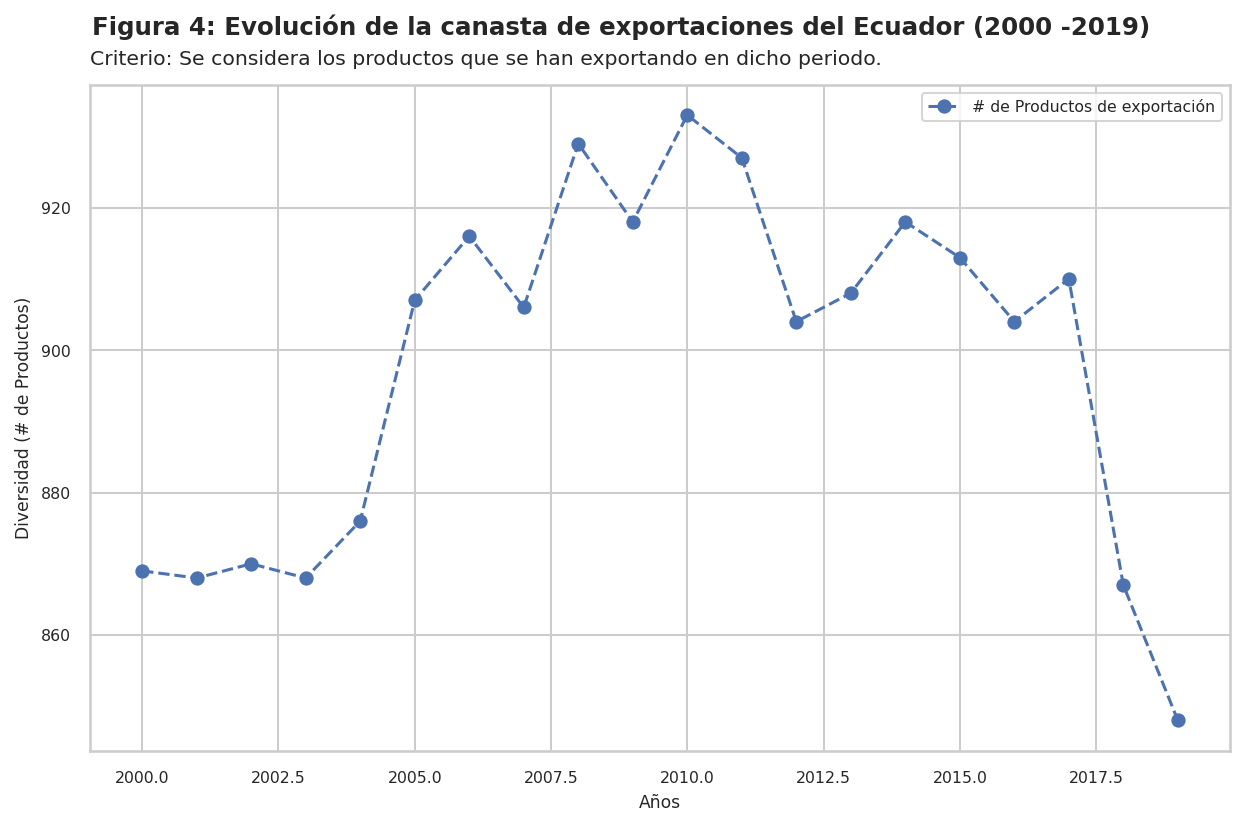

In [259]:


plt.figure(figsize=(10,6))

plt.plot("year", "export_diversity", marker='o', linestyle='dashed',data=exp_div_ec, label = "# de Productos de exportación")



plt.title('Criterio: Se considera los productos que se han exportando en dicho periodo.',  fontsize=10,
    pad=10,
    loc="left")
plt.suptitle(
    "Figura 4: Evolución de la canasta de exportaciones del Ecuador (2000 -2019)",
    fontsize=12,
    fontweight="bold",
    x=0.126,
    y=0.96,
    ha="left",
)
plt.xlabel('Años')
plt.ylabel('Diversidad (# de Productos)')

plt.legend()
plt.show()


### Gráfico de diversificación de exportaciones según RCA desde el 2010 hasta 2019

In [245]:
b = df_rca_ec.copy()

rca_div_ec=b.groupby('year')['RCAcpt'].apply(lambda x: (x>1).sum()).reset_index(name='RCA>1')

years=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]

rca_div_ec = rca_div_ec[(df['year'].isin(years))].copy()

rca_div_ec.head(6)

,year,RCA>1
5,2000,99
6,2001,104
7,2002,99
8,2003,97
9,2004,90
10,2005,87


<Figure size 1470x882 with 0 Axes>

Text(0.5, 1.0, 'Criterio: Evolución de productos con VCR>=1 en comparación a la diversidad de exportaciones en el mismo periodo')

Text(0.126, 0.96, 'Figura 4: EVOLUCIÓN DE LA DIVERSIDAD DE PRODUCTOS EXPORTADOS (2000-2019)')

Text(0.5, 0, 'Años')

Text(0, 0.5, 'Diversidad (# de Productos)')

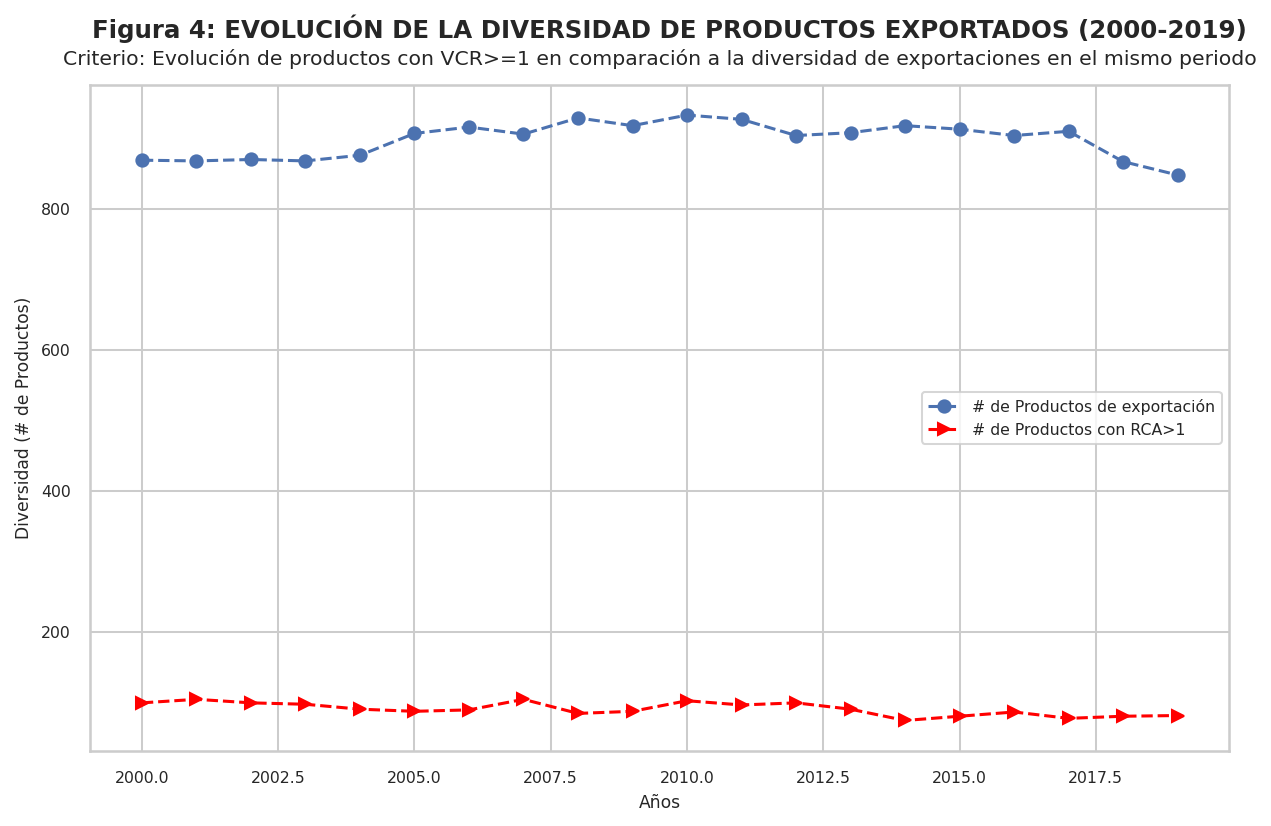

In [274]:
plt.figure(figsize=(10,6))

plt.plot("year", "export_diversity", marker='o', linestyle='dashed',data=exp_div_ec, label = "# de Productos de exportación")
plt.plot("year", "RCA>1", marker='>', linestyle='dashed',color = 'red',data=rca_div_ec, label = "# de Productos con RCA>1")



plt.title('Criterio: Evolución de productos con VCR>=1 en comparación a la diversidad de exportaciones en el mismo periodo',  fontsize=10,
    pad=10,
    loc="center")
plt.suptitle(
    "Figura 4: EVOLUCIÓN DE LA DIVERSIDAD DE PRODUCTOS EXPORTADOS (2000-2019)",
    fontsize=12,
    fontweight="bold",
    x=0.126,
    y=0.96,
    ha="left",
)
plt.xlabel('Años')
plt.ylabel('Diversidad (# de Productos)')

plt.legend()
plt.show()

### Unimos ambas gráficas en subplots

In [260]:
exports_merged = pd.merge(rca_div_ec, exp_div_ec[['year','export_diversity']],how='inner', on='year').copy()
exports_merged.head()

,year,RCA>1,export_diversity
0,2000,99,869
1,2001,104,868
2,2002,99,870
3,2003,97,868
4,2004,90,876


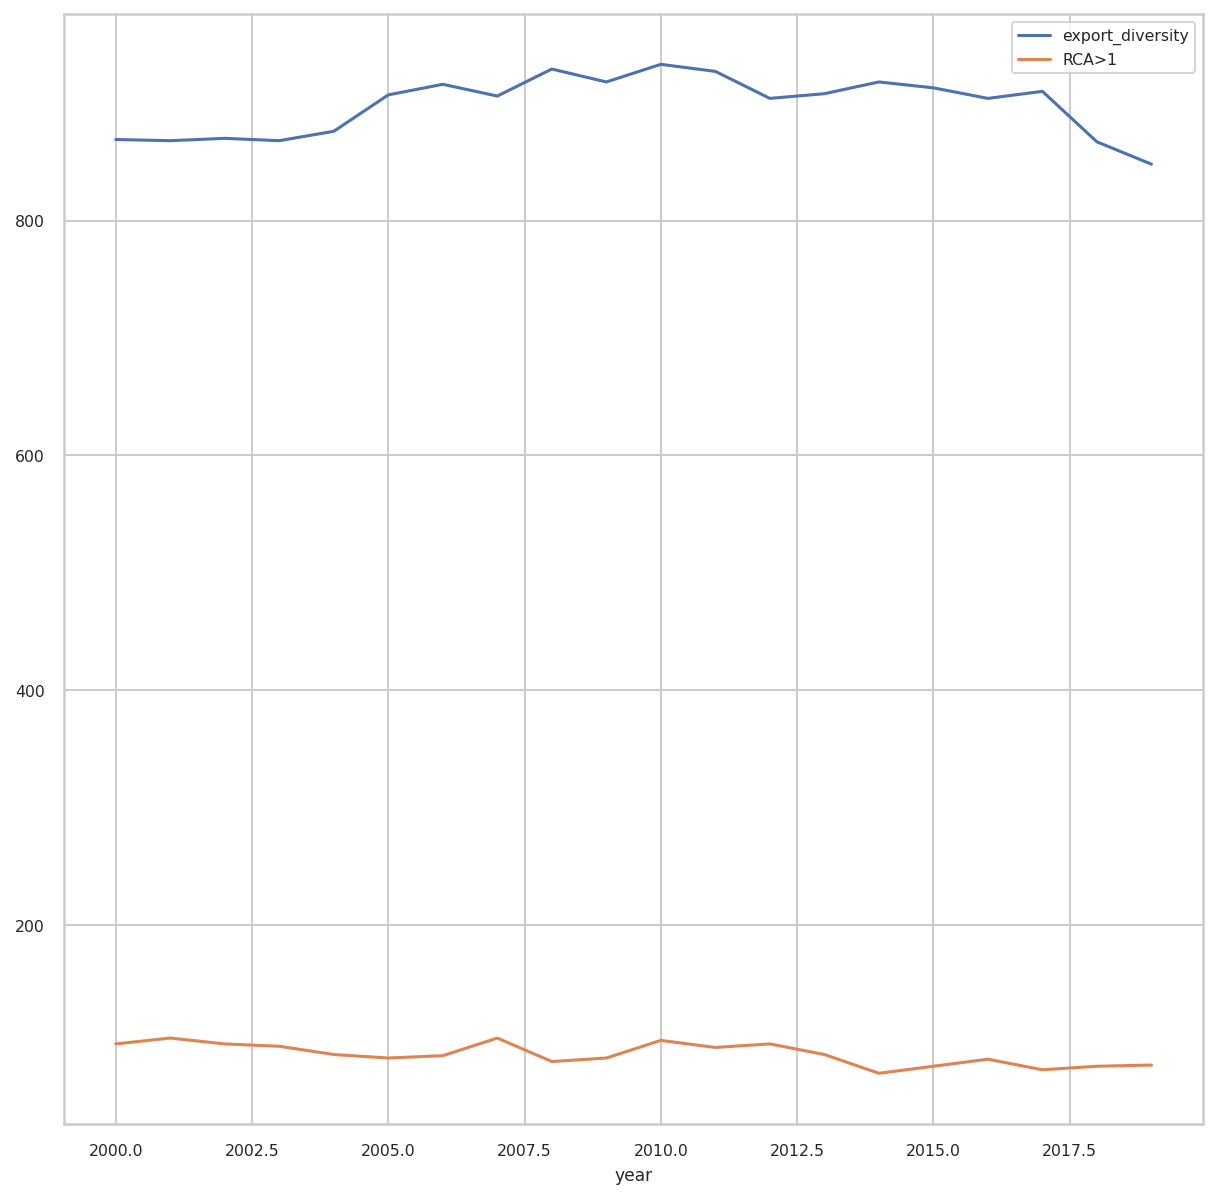

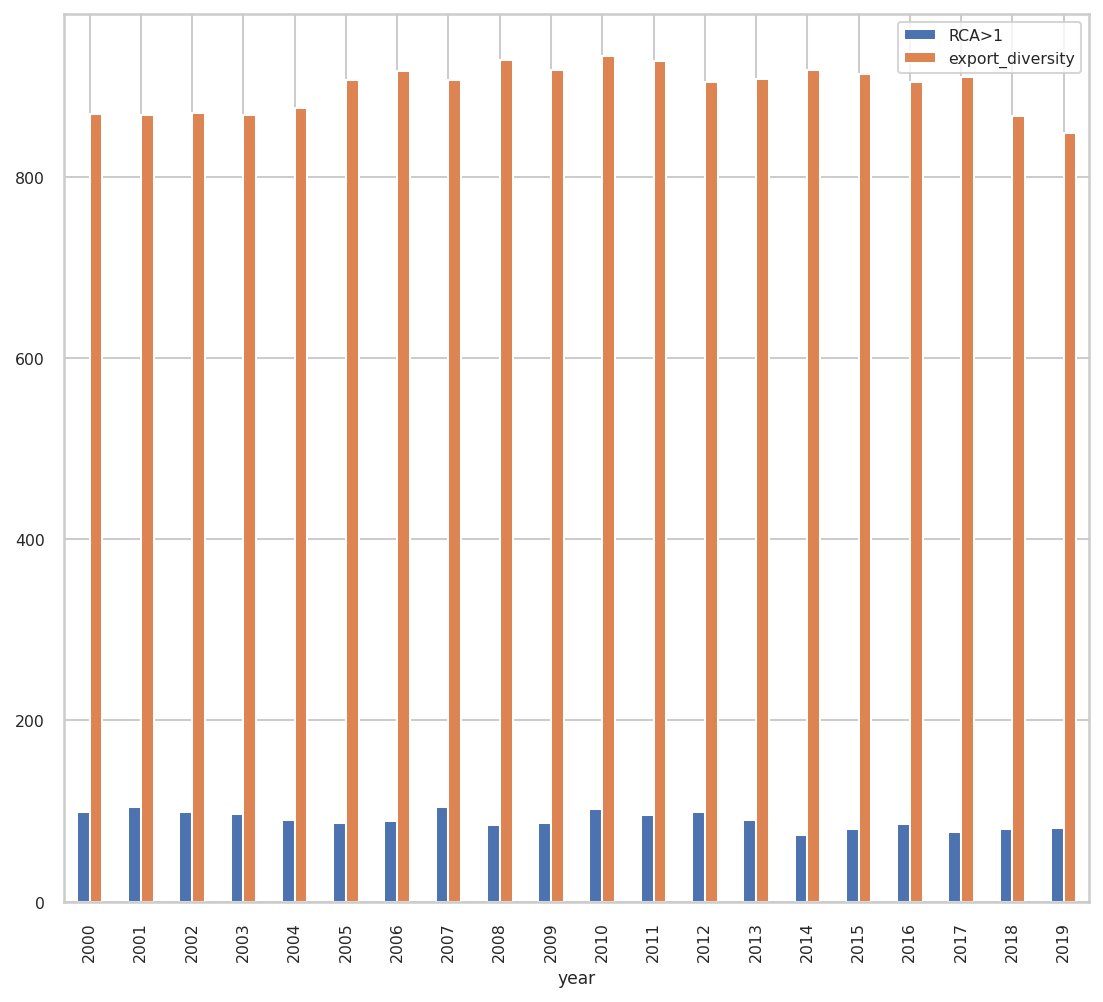

In [265]:
# plot multiple columns such as population and year from dataframe
exports_merged.plot(x="year", y=["export_diversity","RCA>1"],
        kind="line", figsize=(10, 10))
 
# display plot
plt.show()

# plot the dataframe
exports_merged.plot(x="year", y=["RCA>1", "export_diversity"], kind="bar", figsize=(9, 8))
 
# print bar graph
plt.show()

# 2. Cálculos de Sofisticación

According to *Hausmann Hwang & Rodrik’s (2005)*, the authors measure this sophistication indirectly by examining the wages of countries
who are intensive exporters of each product. First, they measure the sophistication of each
product, which they call PRODY, which is the revealed comparative advantage (RCA)-weighted
GDP per capita of each country that exports the good:



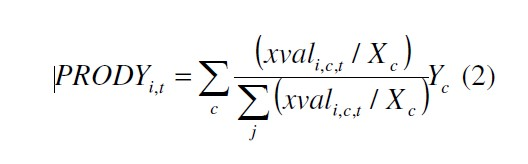

This is a measure calculated as the GDP per
capita of countries that produce it, weighted by their revealed comparative advantage in
that product. As mentioned above, Hausmann Hwang & Rodrik use this product-level variable to calculate the level of sophistication of a country’s export basket, EXPYc,t as
the PRODYi,t for each component of the country’s export basket weighted by its share.

In [ ]:
def calc_prody(data,pais_col,prod_col,anio_col,export_col, gdp_per_capita_col):
    
    """
      Función que calcula el valor de Prody
      Xc: equals total exports by country c, 
      Yc: equals GDP per capita of country c.

    """
    """
      Where xvali,c,t equals exports of good i by country c in year t

    """
    print('En esta parte de la funcion se crea la combinación de producto-i, país-c y tiempo-t')
    df_prody = pd.DataFrame(list(product(data[anio_col].unique(),data[pais_col].unique(),data[prod_col].unique())))
    df_prody.columns=[anio_col,pais_col,prod_col]
    print('Se procede a fusionar los datos')
    df_prody = pd.merge(df_prody,data[[anio_col,pais_col,prod_col,export_col,gdp_per_capita_col]],how='left',on=[anio_col,pais_col,prod_col])
    df_prody.loc[df_prody[export_col].isnull(),export_col] = 0

    print('Se hace el calculo de RCA')

    df_prody['Xcpt'] = df_prody[export_col]
    df_prody['Xct'] = df_prody.groupby([pais_col, anio_col])[export_col].transform(sum)
    df_prody['Xpt'] = df_prody.groupby([prod_col, anio_col])[export_col].transform(sum)
    df_prody['Xt'] = df_prody.groupby([anio_col])[export_col].transform('sum')
    # df_prody['Yc'] = df_prody.groupby([pais_col, anio_col])[gdp_per_capita_col]
    df_prody['Yc'] = df_prody[gdp_per_capita_col]
    # yc_value = data.groupby(anio_col)[]
    # df_xval = data.groupby(export_col).transform('sum')
    df_prody['RCAcpt'] = (df_prody['Xcpt']/df_prody['Xct'])/(df_prody['Xpt']/df_prody['Xt']) #--> ecuación de las RCA
    df_prody.loc[df_prody['RCAcpt'].isnull(),'RCAcpt'] = 0

    print('Se hace el calculo de PRODY')

    df_prody['PRODY'] = ((df_prody['Xcpt']/df_prody['Xct'])/(df_prody['Xpt']/df_prody['Xt']))*df_prody['Yc'] 

    #retiro las propiedadades del dataframe 
    df_prody.drop(['Xcpt','Xct','Xpt','Xt','Yc'],axis=1,inplace=True,errors='ignore')


    return df_prody



In [ ]:
# !git --version
# !git config --global user.name "descandon88"
# !git config --global user.email "david.escandon.v@gmail.com"


In [ ]:
df_prody = calc_prody(data=df_merge,pais_col='country_name',prod_col='product_name',anio_col='year',export_col='export_value',gdp_per_capita_col='gdp_per_capita').copy()
df_prody.sample(n=10)

En esta parte de la funcion se crea la combinación de producto-i, país-c y tiempo-t
Se procede a fusionar los datos
Se hace el calculo de RCEA
Se hace el calculo de PRODY


,year,country_name,product_name,export_value,gdp_per_capita,RCAcpt,PRODY
4574007,2019,Spain,"Bells, gongs and the like; non-electric, statuettes, other ornaments, photograph, picture, similar frames, mirrors, of base metal",28767564.00,29581.52,0.66,19604.64
426327,2001,Seychelles,Halogenated derivatives of hydrocarbons,0.00,7663.14,0.00,0.00
4102228,2017,Ethiopia,"Binoculars, monoculars, other optical telescopes, mountings therefor; other astronomical instruments, mountings therefor, but not including instruments for radio-astronomy",7904.00,755.75,0.04,28.97
2261120,2009,Madagascar,"Fabrics; knitted or crocheted, other than those of heading no. 6001",2148098.00,455.41,1.57,715.09
2955221,2012,Kazakhstan,"Articles of gut (other than silk-worm gut), of goldbeater's skin, of bladders or of tendons",0.00,12386.70,0.00,0.00
1450249,2006,Belize,"Alloy steel in ingots or other primary forms, semi-finished products of other alloy steel",0.00,5475.72,0.00,0.00
1084240,2004,Mongolia,"Roundabouts, swings, shooting galleries, other fairground amusements, travelling circuses, travelling menageries and travelling theatres",1707.00,784.91,0.03,23.58
2286632,2009,Nauru,Flours and meals of oil seeds or oleaginous fruits; other than those of mustard,0.00,NaN,0.00,NaN
3166169,2013,Guinea-Bissau,Radioactive chemical elements and radioactive isotopes (including the fissile or fertile chemical elements and isotopes); and their compounds; mixtures and residues containing these products,0.00,616.16,0.00,0.00
231151,2000,Namibia,"Margarine; edible mixtures or preparations of animal or vegetable fats or oils or of fractions of different fats or oils of this chapter, other than edible fats or oils of heading no. 1516",186479.00,2156.10,1.13,2429.42


In [ ]:
df_prody[ (df_prody['country_name']=='Ecuador')].sort_values(by=['year'],ascending=True)[['product_name','export_value','year','gdp_per_capita','RCAcpt','PRODY']].copy()

,product_name,export_value,year,gdp_per_capita,RCAcpt,PRODY
62100,"Horses, asses, mules and hinnies; live",56778.00,2000,1451.53,0.03,50.12
62932,"Stainless steel bars and rods, hot-rolled, in irregularly wound coils",330106.00,2000,1451.53,0.42,613.76
62931,Stainless steel; flat-rolled products of width less than 600mm,0.00,2000,1451.53,0.00,0.00
62930,Stainless steel; flat-rolled products of width of 600mm or more,146909.00,2000,1451.53,0.01,21.62
62929,Stainless steel in ingots or other primary forms; semi-finished products of stainless steel,0.00,2000,1451.53,0.00,0.00
...,...,...,...,...,...,...
4569728,Safety fuses; detonating fuses; percussion or detonating caps; igniters; electric detonators,0.00,2019,6233.26,0.00,0.00
4569727,"Prepared explosives, other than propellent powders",0.00,2019,6233.26,0.00,0.00
4569726,Explosives; propellent powders,0.00,2019,6233.26,0.00,0.00
4569733,"Photographic film in rolls, sensitised, unexposed, of any material other than paper, paperboard or textiles; instant print film in rolls, sensitised, unexposed",0.00,2019,6233.26,0.00,0.00


##Cálculo de EXPY


This product-level measure of sophistication is then used to measure the sophistication of
a country’s export basket as a whole. The authors call this measure EXPY. EXPY is simply the
PRODY of each good (i) that country c exports, weighted by that good’s share in the country’s
export basket (Xc). It represents the income level associated with a country’s overall export
package.

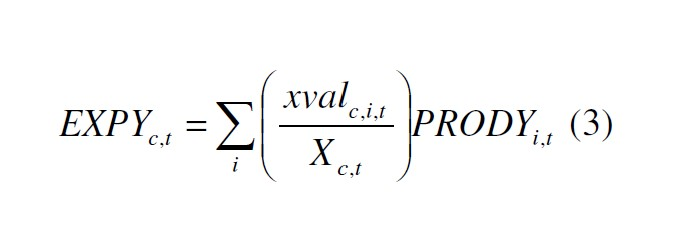

In [ ]:
def calc_expy(data,pais_col,prod_col,anio_col,export_col, gdp_per_capita_col):
  """
  Función para el cálculo de EXPY c,t
  """
  print('En esta parte de la funcion se crea la combinación de producto-i, país-c y tiempo-t')
  df_expy = pd.DataFrame(list(product(data[anio_col].unique(),data[pais_col].unique(),data[prod_col].unique())))
  df_expy.columns=[anio_col,pais_col,prod_col]
  print('Se procede a fusionar los datos')